In [2]:
from pandas_datareader import DataReader
from datetime import datetime
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from math import sqrt

In [3]:
def GARCH(Y):
 "Initialize Params:"
 mu = param0[0]
 omega = param0[1]
 alpha = param0[2]
 beta = param0[3]
 T = Y.shape[0]
 GARCH_Dens = np.zeros(T) 
 sigma2 = np.zeros(T)   
 F = np.zeros(T)   
 v = np.zeros(T)   
 for t in range(1,T):
    sigma2[t] = omega + alpha*((Y[t-1]-mu)**2)+beta*(sigma2[t-1]); 
    F[t] = Y[t] - mu-np.sqrt(sigma2[t])*np.random.normal(0,1,1)
    v[t] = sigma2[t]
    GARCH_Dens[t] = (1/2)*np.log(2*np.pi)+(1/2)*np.log(v[t])+\
                    (1/2)*(F[t]/v[t])     
    Likelihood = np.sum(GARCH_Dens[1:-1])  
    return Likelihood

In [4]:
def GARCH_PROD(params, Y0, T):
 mu = params[0]
 omega = params[1]
 alpha = params[2]
 beta = params[3]
 Y = np.zeros(T)  
 sigma2 = np.zeros(T)
 Y[0] = Y0
 sigma2[0] = 0.0001
 for t in range(1,T):
    sigma2[t] = omega + alpha*((Y[t-1]-mu)**2)+beta*(sigma2[t-1]); 
    Y[t] = mu+np.sqrt(sigma2[t])*np.random.normal(0,1,1)    
 return Y  

In [5]:
# Ten year data for P&G:
PG = DataReader('PG',  'yahoo', datetime(2009,1,1), datetime(2019,12,31));

# Avergae of opening and closing:
avg = list()
for i in range(len(PG)):
    avg = (PG["Open"] + PG["Close"])/2
PG["Average"] = avg

# Required Dataset: 
PG.head()

,High,Low,Open,Close,Volume,Adj Close,Average
Date,,,,,,,
2009-01-02,62.970001,61.060001,61.689999,62.799999,11135700.0,44.174007,62.244999
2009-01-05,62.439999,61.590000,62.320000,62.349998,14322800.0,43.857475,62.334999
2009-01-06,62.950001,61.509998,62.500000,62.169998,13401600.0,43.730865,62.334999
2009-01-07,61.660000,60.639999,61.330002,61.080002,12415600.0,42.964157,61.205002
2009-01-08,61.250000,60.000000,60.910000,60.410000,11508100.0,42.492859,60.660000


         Current function value: -140.965356
         Iterations: 2
         Function evaluations: 201
         Gradient evaluations: 31


C:\Users\parth\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: OptimizeWarning: Unknown solver options: xtol
  import sys


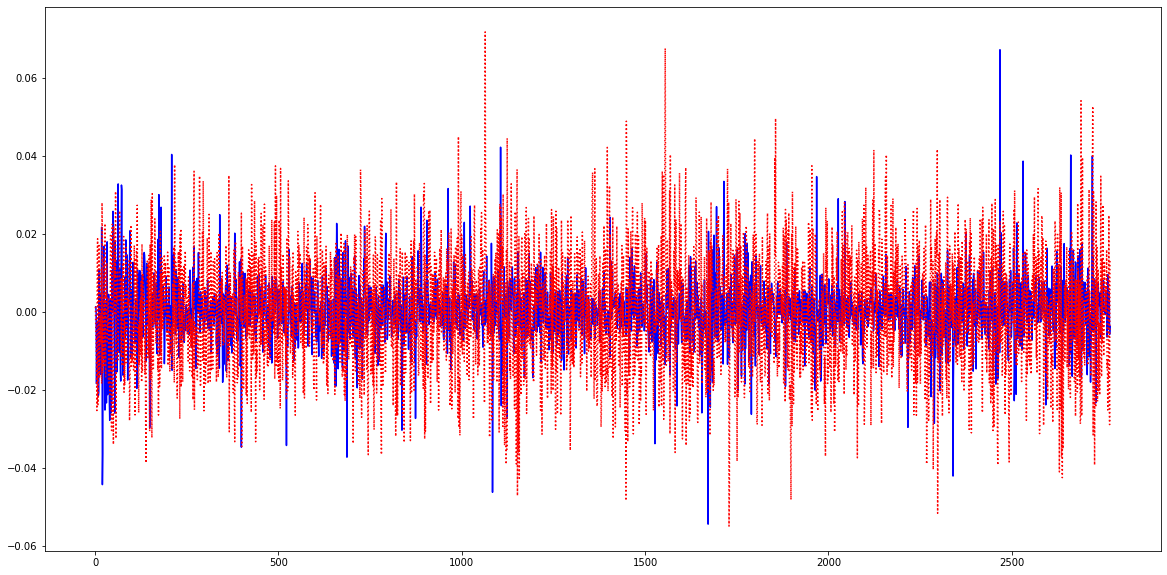

In [10]:
T=PG.shape[0]
PG['log_return'] = np.log(PG['Average'] / PG['Average'].shift(periods=1))
mu = PG['log_return'].mean()
omega = PG['log_return'].var()
Y = PG['log_return']
param0 = np.array([mu, omega, 0.2, 0.5])
param_star = minimize(GARCH, param0, method='BFGS', options={'xtol': 1e-16, 'disp': True})
Y_GARCH = GARCH_PROD(param_star.x, Y[1], T)
timevec = np.linspace(1,T,T)
plt.figure(figsize=(20,10))
plt.plot(timevec, Y,'b',timevec, Y_GARCH,'r:')

In [12]:
Y_dash = np.exp(Y_GARCH) * PG['Average'].shift(periods=1)
mean_error = np.mean(Y_dash - PG['Average'])
rms = sqrt(mean_squared_error(PG['Average'], Y_dash.fillna(0)))

In [13]:
rms

1.8096284255362902